In [1]:
import torch
import argparse
from model import GPT
from utils import generate
from utils import getLoaderDataset
from utils import Args
from train import Training

args = Args()
print(args)
train = Training(args)
model, metrics = train.train_model()
print(train.tokenized_data.decode(
    generate(model, train.tokenized_data.encode("Oh God Oh God !"), 50)
))

Args(batch_size=10, n_tokens=64, n_layers=4, n_heads=4, d_model=128, use_lr_decay=True, lr=0.001, dataset_path='./datasets/shakespear_corpus.txt', max_iter=100, out_dir='./runs/', n_warm_iters=100, lr_decay_iter=5000, min_lr=0.0001, n_validation_batch=200, betas=(0.9, 0.99), n_epochs=10, val_int=100, save=True, save_int=200, name='milkshake', cross_val=False, k_fold=10)


AttributeError: 'Training' object has no attribute 'train_model'

In [ ]:
N = 64
B = 12
loader, dataset = getLoaderDataset(N, B, "./datasets/shakespear_corpus.txt")

In [ ]:
N = 64
B = 12
loader, token_dataset = getLoaderDataset(N, B, "./datasets/shakespear_corpus.txt")
print(len(token_dataset))

1003853 64
1003853 64
1003853 64
1003789


In [ ]:
L = 12
d = 768
d_ff = 4 * d
h = 8
V = dataset.get_vocab_size()
print(V)
model = GPT(B, L, d, d_ff, N, h, V)

In [18]:
new_tokens = generate(model, dataset.encode("Hello World"), 100)
print(dataset.decode(new_tokens))

In [ ]:
N = 64
B = 12
L = 6
d = 128
d_ff = 4 * d
h = 6
V = dataset.get_vocab_size()

In [ ]:
B = 12
N = 64  # context of up to 256 previous characters
L = 4
h = 4
d = 128
learning_rate = 1e-3
use_lr_decay = False
dataset = './datasets/shakespear_corpus.txt'
out_dir = './runs/'

max_iterations = 1000

class Args(argparse.Namespace):
    batch_size:int = B
    n_tokens:int = N
    n_layers:int = L
    n_heads:int = h
    d_model:int = d
    use_lr_decay:bool = use_lr_decay
    learning_rate: float = learning_rate
    dataset: str = dataset
    max_iterations: int = max_iterations
    out: str = out_dir

In [ ]:
model, losses, perplexities = train_model(Args())

In [2]:
import torch

B = 12
N = 64  # context of up to 256 previous characters
L = 4
h = 4
d = 128
learning_rate = 1e-3
betas = (0.9, 0.99)
eps = 10e-9
n_warmup_iterations = 100
learning_rate_decay_iterations = 5000
min_learning_rate = 1e-4
use_lr_decay = True
loader, dataset = getLoaderDataset(N, B, "./datasets/shakespear_corpus.txt")

model = GPT(B, L, d, 3*d, N, h, V)

cpkt = torch.load("./runs/long_model_b128_t256_l16_h16_d256.pt", map_location=torch.device('cpu'))
model.load_state_dict(cpkt)
print(model)

TypeError: getLoaderDataset() missing 2 required positional arguments: 'fold' and 'k_fold'

In [ ]:
from utils import generate

new_tokens = generate(model, dataset.encode("Hello World"), 300)
print(dataset.decode(new_tokens))

In [5]:
from utils import CharDataSet

In [53]:
B = 128
N = 256  # context of up to 256 previous characters
L = 16
h = 16
d = 256


data = CharDataSet(B, dataset_path='./datasets/shakespear_corpus.txt')

V = data.get_vocab_size()

print(V)
model = GPT(B, L, d, 3*d, N, h, V)

cpkt = torch.load("./runs/long_model_b128_t256_l16_h16_d256/long_model_b128_t256_l16_h16_d256_3_30000.pt", map_location=torch.device('cpu'))
model.load_state_dict(cpkt['model'])



./datasets/shakespear_corpus.txt
65


<All keys matched successfully>

In [54]:
new_tokens = generate(model, data.encode("I understand thee well"), 100)


print(data.decode(new_tokens))

I understand thee well!
Thou desperate pilot, now at once run on
The dashing rocks thy sea-sick weary bark!
Here's to my l


In [58]:
print(cpkt['train_loss'].size())

torch.Size([30000])


dict_keys(['model', 'valid_loss', 'train_loss', 'params'])


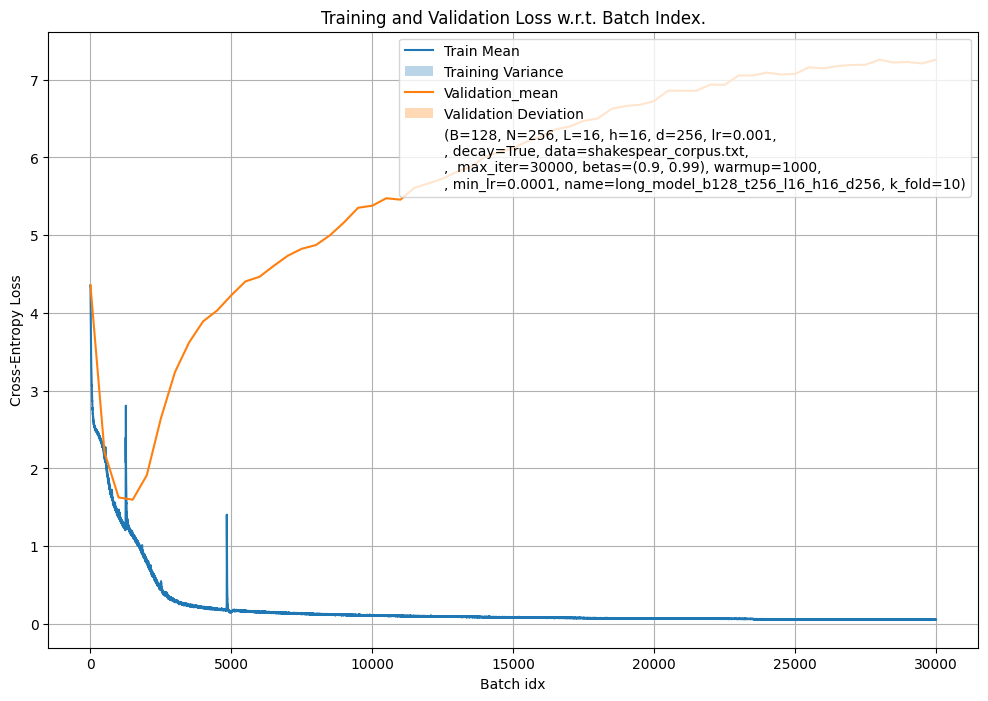

In [59]:
print(cpkt.keys())
from utils import cv_losses_graph

cv_losses_graph(
    cpkt ['train_loss'].unsqueeze(0), cpkt['valid_loss'].unsqueeze(0), 
    cpkt['params']['val_int'], './runs/long_model_b128_t256_l16_h16_d256/', # save graph to same folder
    True, "chill_model", cpkt['params']          
)

In [ ]:
import torch
from utils import cv_losses_graph, perplexity_graph

cross_val_run = torch.load(f'{path}/total_cross_val_metrics.pt')   # load final recap file.
print(cross_val_run.keys())
print(cross_val_run['k_fold_train_loss'].size())


perplexity_graph(
    cross_val_run ['k_fold_train_loss'], cross_val_run['k_fold_valid_loss'], 
    cross_val_run['params']['val_int'], path, # save graph to same folder
    True, "chill_model", cross_val_run['params']          
)


In [34]:
B = 128
N = 256  # context of up to 256 previous characters
L = 16
h = 16
d = 256


data = CharDataSet(B, dataset_path='./datasets/shakespear_corpus.txt')

V = data.get_vocab_size()

print(V)
model = GPT(B, L, d, 3*d, N, h, V)

cpkt = torch.load("./runs/long_model_b128_t256_l16_h16_d256/long_model_b128_t256_l16_h16_d256_0_5000.pt", map_location=torch.device('cpu'))
model.load_state_dict(cpkt['model'])



./datasets/shakespear_corpus.txt
65


<All keys matched successfully>

In [52]:
new_tokens = generate(model, data.encode("FRANCOIS:\nI am getting married.\n\nJULIEN:"), 500)


print(data.decode(new_tokens))

FRANCOIS:
I am getting married.

JULIEN:
O fair charged you news by his mother's womb:
And so I am in honour to depition
That I am now my scolding Lord or William Lord Hastings,
Untainled of good husband, for shall hap the court
In hurt be his great father. Good man.

VALERIA:
In the choler of things twenty land and safellow.

First Lord:
Be good-morrow, my lord, give to my kinsmer's pleasure
And bend an hold prochess and my armouth;
And whitherer belling and and and change amon,
Sand chond and and and and pat thand penearsss?
Tin But
